In [1]:
# !pip install classification-models-3D
# !pip install keras_applications
# !pip install ipython
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import tensorflow as tf
from keras.metrics import AUC
from keras.models import Model
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.animation as animation
from sklearn.metrics import roc_auc_score
from keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from classification_models_3D.tfkeras import Classifiers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, Conv3D, BatchNormalization, Activation, Concatenate
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, GlobalAveragePooling3D

In [ ]:
## Converts nii to jpg middle slice
# import os
# import nibabel as nib
# import matplotlib.pyplot as plt
# # Define the input and output folder names
# input_folders = ['MCI', 'AD', 'CN']
# output_folders = ['MCI_JPG', 'AD_JPG', 'CN_JPG']
# # Create output folders if they don't exist
# for output_folder in output_folders:
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
# # Function to convert .nii files to JPG
# def convert_nii_to_jpg(input_folder, output_folder):
#     for file in os.listdir(input_folder):
#         if file.endswith('.nii'):
#             # Load the .nii file
#             nii_file_path = os.path.join(input_folder, file)
#             img = nib.load(nii_file_path)
#             data = img.get_fdata()
#             # Get the middle sagittal slice index
#             middle_slice_index = data.shape[0] // 2
#             # Save the middle sagittal slice as a JPG image
#             slice_img = data[middle_slice_index, :, :].T
#             output_file_path = os.path.join(output_folder, f'{os.path.splitext(file)[0]}.jpg')
#             plt.imsave(output_file_path, slice_img, cmap='gray')
# # Process the folders
# for input_folder, output_folder in zip(input_folders, output_folders):
#     convert_nii_to_jpg(input_folder, output_folder)
# print("Conversion complete.")

In [2]:
# images_types_present = ['AD/I50426', 'MCI/I42292', 'CN/I42785']
# fig, axes = plt.subplots(2, len(images_types_present), figsize=(10, 7))
# target_shape = (192, 192, 160)
# for i, image_type in enumerate(images_types_present):
#     images_types_path = f"dataset/{image_type}.nii"
#     images_types_data = nib.load(images_types_path).get_fdata()
#     # Calculate zoom factors for each dimension
#     zoom_factors = [target_shape[dim] / images_types_data.shape[dim] for dim in range(3)]
#     # Reshape the data using the zoom factors
#     reshaped_data = zoom(images_types_data, zoom_factors, order=3)
#     # Plot the axial slice at [shape[0] // 2 - 30, :, :]
#     axes[0, i].imshow(reshaped_data[reshaped_data.shape[0] // 2 - 30, :, :], cmap='inferno')
#     axes[0, i].set_title(image_type.split('/')[0])
#     axes[0, i].set_xticks([])  # remove x tick labels
#     axes[0, i].set_yticks([])  # remove y tick labels
#     axes[0, i].text(0.5, -0.125, f'{30}th Slice\nout of {target_shape[2]} Volume Slices', fontsize=9, transform=axes[0, i].transAxes, ha='center')  # add slice value above plot
#     # Plot the slice at [shape[0] // 2 - 30]
#     axes[1, i].imshow(reshaped_data[:, :, reshaped_data.shape[0] // 2 - 30], cmap='inferno')
#     axes[1, i].set_title(image_type.split('/')[0])
#     axes[1, i].set_xticks([])  # remove x tick labels
#     axes[1, i].set_yticks([])  # remove y tick labels
#     axes[1, i].text(0.5, -0.15, f'{30}th Slice\nout of {target_shape[2]} Volume Slices', fontsize=9, transform=axes[1, i].transAxes, ha='center')  # add slice value above plot
# plt.show()

In [3]:
# images_types_present = ['AD/I33452', 'MCI/I39132', 'CN/I34458']
# fig, axes = plt.subplots(1, len(images_types_present), figsize=(12, 7))
# target_shape = (192, 192, 160)
# fig.tight_layout()
# # Load and reshape images outside the update_axial function
# reshaped_images = []
# for image_type in images_types_present:
#     images_types_path = f"dataset/{image_type}.nii"
#     images_types_data = nib.load(images_types_path).get_fdata()
#     # Calculate zoom factors for each dimension
#     zoom_factors = [target_shape[dim] / images_types_data.shape[dim] for dim in range(3)]
#     # Reshape the data using the zoom factors
#     reshaped_data = zoom(images_types_data, zoom_factors, order=3)
#     reshaped_images.append(reshaped_data)
# def animate_slices():
#     def update_axial(slice_idx):
#         for i, reshaped_data in enumerate(reshaped_images):
#             axes[i].clear()
#             axes[i].imshow(reshaped_data[slice_idx + 25, :, :], cmap='inferno')
#             axes[i].set_title(f"{images_types_present[i].split('/')[0]} Axial")
#             axes[i].set_xticks([])  # remove x tick labels
#             axes[i].set_yticks([])  # remove y tick labels
#             axes[i].text(0.5, -0.1, f'{slice_idx + 25}th Slice\nout of {target_shape[1]} Volume Slices', fontsize=9, transform=axes[i].transAxes, ha='center')  # add slice value above plot
#     return update_axial
# ani = animation.FuncAnimation(fig, animate_slices(), frames=target_shape[0] - 25 - 5, interval=100, repeat=True)
# ani.save('slices.gif', writer='pillow', fps = 30)

<img src="slices_axial.gif" width="840" height="362" alt="alt text"/>
<br>
<img src="slices_sagittal.gif" width="840" height="342" alt="alt text"/>

In [62]:
class NiiDataGenerator(Sequence):
    """
    This class is a custom data generator that inherits from the Sequence class in Keras. 
    It loads and preprocesses 3D NIfTI images and their corresponding labels.  
    """
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []

        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"input_2": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)

    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)

In [63]:
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()
print(unique_group,unique_visit)
df.head(8)

['MCI' 'CN' 'AD'] ['sc' 'm12' 'm06' 'uns1']


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,2/18/2023
1,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,2/18/2023
2,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,2/18/2023
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,2/18/2023
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,2/18/2023
5,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,2/18/2023
6,I108336,941_S_1197,CN,F,84,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/21/2008,NiFTI,2/18/2023
7,I66462,941_S_1197,CN,F,82,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/20/2007,NiFTI,2/18/2023


In [64]:
def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    # Label encode the 'Subjects' attribute
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])

    # One-hot encode the 'visit' attribute
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)

    class_dict = {"AD": 0, "MCI": 1, "CN": 2}

    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        
        # Check if the file exists
        if not os.path.exists(file_path):
            continue

        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])

    return file_paths, labels, gender, age, visit, subjects

# def load_data_paths_labels_features(csv_file_path):
#     df = pd.read_csv(csv_file_path)
#     file_paths = []
#     labels = []
#     gender = []
#     age = []
#     visit = []
#     subjects = []
    
#     # One-hot encode the 'visit' and 'Subjects' attributes
#     visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
#     subjects_dummies = pd.get_dummies(df['Subject'], prefix='subject')
#     df = pd.concat([df, visit_dummies, subjects_dummies], axis=1)

#     class_dict = {"AD": 0, "MCI": 1, "CN": 2}

#     for index, row in df.iterrows():
#         file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        
#         # Check if the file exists
#         if not os.path.exists(file_path):
#             continue

#         file_paths.append(file_path)
#         labels.append(class_dict[row["Group"]])
#         gender.append(1 if row["Sex"] == "M" else 0)
#         age.append(row["Age"])
#         visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
#         subjects.append(row[subjects_dummies.columns].values.tolist())

#     return file_paths, labels, gender, age, visit, subjects

In [65]:
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)

In [66]:
print(train_generator.get_input_shape())

(256, 256, 170, 1)


In [39]:
SEResNeXt101, preprocess_input = Classifiers.get('seresnext101')
base_model = SEResNeXt101(input_shape=(192, 192, 160, 3), weights='imagenet', include_top=False)
# Add a new classification layer with 3 output units (for the 3 classes)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling3D()(x)
# Additional feature inputs
gender_input = tf.keras.layers.Input(shape=(1,), name="gender_input")
age_input = tf.keras.layers.Input(shape=(1,), name="age_input")
visit_input = tf.keras.layers.Input(shape=(4,), name="visit_input")
subjects_input = tf.keras.layers.Input(shape=(1,), name="subjects_input")  


subjects_encoded = tf.keras.layers.CategoryEncoding(num_tokens=555, output_mode="one_hot")(subjects_input)
subjects_flattened = tf.keras.layers.Flatten(name="subjects_flattened")(subjects_encoded)

# Concatenate image and additional features
merged_features = tf.keras.layers.concatenate([x, gender_input, age_input, visit_input,subjects_flattened])

x = tf.keras.layers.Dense(1024, activation='relu')(merged_features)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=[base_model.input, gender_input, age_input, visit_input, subjects_input], outputs=predictions)

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function, optimizer, and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc', multi_label=True)])

checkpoint = ModelCheckpoint('multi_modal.h5', monitor='val_accuracy', mode = 'max', save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,min_delta=0,min_lr =1e-7,)

In [40]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks = [checkpoint,reduce_lr])

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.3835 - accuracy: 0.4270 - auc: 0.5633
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to multi_modal.h5
83/83 [==============================] - 319s 4s/step - loss: 1.3835 - accuracy: 0.4270 - auc: 0.5633 - val_loss: 0.9951 - val_accuracy: 0.5156 - val_auc: 0.6449 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.1607 - accuracy: 0.5211 - auc: 0.6539
Epoch 2: val_accuracy improved from 0.51562 to 0.55000, saving model to multi_modal.h5
83/83 [==============================] - 279s 3s/step - loss: 1.1607 - accuracy: 0.5211 - auc: 0.6539 - val_loss: 0.9514 - val_accuracy: 0.5500 - val_auc: 0.7292 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.7772 - accuracy: 0.6657 - auc: 0.8195
Epoch 3: val_accuracy did not improve from 0.55000
83/83 [==============================] - 277s 3s/step - loss: 0.7772 - accuracy: 0.6657 - auc: 0.8195 - 

In [41]:
model.save('models/seresnext101_multi_modal.h5')

In [67]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(input_shape=(192, 192, 160, 3), weights='imagenet', include_top=False)
# Add a new classification layer with 3 output units (for the 3 classes)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling3D()(x)
# Additional feature inputs
gender_input = tf.keras.layers.Input(shape=(1,), name="gender_input")
age_input = tf.keras.layers.Input(shape=(1,), name="age_input")
visit_input = tf.keras.layers.Input(shape=(4,), name="visit_input")
subjects_input = tf.keras.layers.Input(shape=(1,), name="subjects_input")  


subjects_encoded = tf.keras.layers.CategoryEncoding(num_tokens=555, output_mode="one_hot")(subjects_input)
subjects_flattened = tf.keras.layers.Flatten(name="subjects_flattened")(subjects_encoded)

# Concatenate image and additional features
merged_features = tf.keras.layers.concatenate([x, gender_input, age_input, visit_input,subjects_flattened])

x = tf.keras.layers.Dense(1024, activation='relu')(merged_features)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)


model2 = tf.keras.Model(inputs=[base_model.input, gender_input, age_input, visit_input, subjects_input], outputs=predictions)

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function, optimizer, and metrics
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc', multi_label=True)])

checkpoint = ModelCheckpoint('multi_modal2.h5', monitor='val_accuracy', mode = 'max', save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,min_delta=0,min_lr =1e-7,)
history2 = model2.fit(train_generator, validation_data=val_generator, epochs=20, callbacks = [checkpoint,reduce_lr])
model2.save('models/resnet18_multi_modal.h5')

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.4413 - auc: 0.5506
Epoch 1: val_accuracy improved from -inf to 0.56875, saving model to multi_modal2.h5
83/83 [==============================] - 323s 4s/step - loss: 1.2251 - accuracy: 0.4413 - auc: 0.5506 - val_loss: 0.9083 - val_accuracy: 0.5688 - val_auc: 0.8414 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.5625 - auc: 0.6961
Epoch 2: val_accuracy improved from 0.56875 to 0.65312, saving model to multi_modal2.h5
83/83 [==============================] - 298s 4s/step - loss: 0.9590 - accuracy: 0.5625 - auc: 0.6961 - val_loss: 0.8837 - val_accuracy: 0.6531 - val_auc: 0.9675 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.6431 - auc: 0.7779
Epoch 3: val_accuracy improved from 0.65312 to 0.74687, saving model to multi_modal2.h5
83/83 [==============================] - 278s 3s/step - loss: 0.8

In [70]:
class NiiDataGenerator(Sequence):
    """
    This class is a custom data generator that inherits from the Sequence class in Keras. 
    It loads and preprocesses 3D NIfTI images and their corresponding labels.  
    """
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []

        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"input_6": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)

    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()

def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    # Label encode the 'Subjects' attribute
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])

    # One-hot encode the 'visit' attribute
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)

    class_dict = {"AD": 0, "MCI": 1, "CN": 2}

    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        
        # Check if the file exists
        if not os.path.exists(file_path):
            continue

        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])

    return file_paths, labels, gender, age, visit, subjects
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)

VGG16, preprocess_input = Classifiers.get('vgg16')
base_model = VGG16(input_shape=(192, 192, 160, 3), weights='imagenet', include_top=False)
# Add a new classification layer with 3 output units (for the 3 classes)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling3D()(x)
# Additional feature inputs
gender_input = tf.keras.layers.Input(shape=(1,), name="gender_input")
age_input = tf.keras.layers.Input(shape=(1,), name="age_input")
visit_input = tf.keras.layers.Input(shape=(4,), name="visit_input")
subjects_input = tf.keras.layers.Input(shape=(1,), name="subjects_input")  


subjects_encoded = tf.keras.layers.CategoryEncoding(num_tokens=555, output_mode="one_hot")(subjects_input)
subjects_flattened = tf.keras.layers.Flatten(name="subjects_flattened")(subjects_encoded)

# Concatenate image and additional features
merged_features = tf.keras.layers.concatenate([x, gender_input, age_input, visit_input,subjects_flattened])

x = tf.keras.layers.Dense(1024, activation='relu')(merged_features)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)


model3 = tf.keras.Model(inputs=[base_model.input, gender_input, age_input, visit_input, subjects_input], outputs=predictions)

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function, optimizer, and metrics
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc', multi_label=True)])

checkpoint = ModelCheckpoint('multi_modal3.h5', monitor='val_accuracy', mode = 'max', save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,min_delta=0,min_lr =1e-7,)
history3 = model3.fit(train_generator, validation_data=val_generator, epochs=20, callbacks = [checkpoint,reduce_lr])
model3.save('models/vgg16_multi_modal.h5')

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.2918 - accuracy: 0.3998 - auc: 0.5334
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to multi_modal3.h5
83/83 [==============================] - 318s 4s/step - loss: 1.2918 - accuracy: 0.3998 - auc: 0.5334 - val_loss: 1.1304 - val_accuracy: 0.2500 - val_auc: 0.8141 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.5708 - auc: 0.7233
Epoch 2: val_accuracy improved from 0.25000 to 0.67188, saving model to multi_modal3.h5
83/83 [==============================] - 296s 4s/step - loss: 0.9168 - accuracy: 0.5708 - auc: 0.7233 - val_loss: 0.7952 - val_accuracy: 0.6719 - val_auc: 0.9193 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.7447 - auc: 0.9123
Epoch 3: val_accuracy improved from 0.67188 to 0.85312, saving model to multi_modal3.h5
83/83 [==============================] - 295s 4s/step - loss: 0.7

In [71]:
class NiiDataGenerator(Sequence):
    """
    This class is a custom data generator that inherits from the Sequence class in Keras. 
    It loads and preprocesses 3D NIfTI images and their corresponding labels.  
    """
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []

        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"input_7": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)

    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()

def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    # Label encode the 'Subjects' attribute
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])

    # One-hot encode the 'visit' attribute
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)

    class_dict = {"AD": 0, "MCI": 1, "CN": 2}

    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        
        # Check if the file exists
        if not os.path.exists(file_path):
            continue

        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])

    return file_paths, labels, gender, age, visit, subjects
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)

DenseNet121, preprocess_input = Classifiers.get('densenet121')
base_model = DenseNet121(input_shape=(192, 192, 160, 3), weights='imagenet', include_top=False)
# Add a new classification layer with 3 output units (for the 3 classes)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling3D()(x)
# Additional feature inputs
gender_input = tf.keras.layers.Input(shape=(1,), name="gender_input")
age_input = tf.keras.layers.Input(shape=(1,), name="age_input")
visit_input = tf.keras.layers.Input(shape=(4,), name="visit_input")
subjects_input = tf.keras.layers.Input(shape=(1,), name="subjects_input")  


subjects_encoded = tf.keras.layers.CategoryEncoding(num_tokens=555, output_mode="one_hot")(subjects_input)
subjects_flattened = tf.keras.layers.Flatten(name="subjects_flattened")(subjects_encoded)

# Concatenate image and additional features
merged_features = tf.keras.layers.concatenate([x, gender_input, age_input, visit_input,subjects_flattened])

x = tf.keras.layers.Dense(1024, activation='relu')(merged_features)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)


model4 = tf.keras.Model(inputs=[base_model.input, gender_input, age_input, visit_input, subjects_input], outputs=predictions)

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss function, optimizer, and metrics
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc', multi_label=True)])

checkpoint = ModelCheckpoint('multi_modal4.h5', monitor='val_accuracy', mode = 'max', save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,min_delta=0,min_lr =1e-7,)
history4 = model4.fit(train_generator, validation_data=val_generator, epochs=20, callbacks = [checkpoint,reduce_lr])
model4.save('models/densenet121_multi_modal.h5')

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.6016 - accuracy: 0.4330 - auc: 0.5467
Epoch 1: val_accuracy improved from -inf to 0.34375, saving model to multi_modal4.h5
83/83 [==============================] - 294s 3s/step - loss: 1.6016 - accuracy: 0.4330 - auc: 0.5467 - val_loss: 1.7128 - val_accuracy: 0.3438 - val_auc: 0.6438 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.5158 - auc: 0.6807
Epoch 2: val_accuracy improved from 0.34375 to 0.50313, saving model to multi_modal4.h5
83/83 [==============================] - 284s 3s/step - loss: 1.0643 - accuracy: 0.5158 - auc: 0.6807 - val_loss: 1.3969 - val_accuracy: 0.5031 - val_auc: 0.7497 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.8847 - accuracy: 0.6137 - auc: 0.7575
Epoch 3: val_accuracy improved from 0.50313 to 0.66250, saving model to multi_modal4.h5
83/83 [==============================] - 285s 3s/step - loss: 0.8

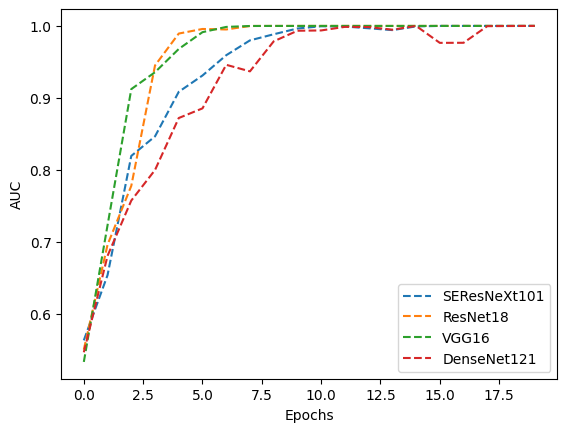

In [74]:
# Access the AUC values
auc_values = history.history['auc']
auc_values2 = history2.history['auc']
auc_values3 = history3.history['auc']
auc_values4 = history4.history['auc']

# Plot the AUC
plt.plot(auc_values, linestyle='dashed',label='SEResNeXt101')
plt.plot(auc_values2, linestyle='dashed',label='ResNet18')
plt.plot(auc_values3, linestyle='dashed',label='VGG16')
plt.plot(auc_values4, linestyle='dashed',label='DenseNet121')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [75]:
loaded_model1 = load_model('models/seresnext101_multi_modal.h5')
loaded_model2 = load_model('models/resnet18_multi_modal.h5')
loaded_model3 = load_model('models/vgg16_multi_modal.h5')
loaded_model4 = load_model('models/densenet121_multi_modal.h5')

In [81]:
class NiiDataGenerator(Sequence):
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return len(self.file_paths) // self.batch_size
    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []
        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"input": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)
    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()
def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)
    class_dict = {"AD": 0, "MCI": 1, "CN": 2}
    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        if not os.path.exists(file_path):
            continue
        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])
    return file_paths, labels, gender, age, visit, subjects
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)
y_pred1 = loaded_model1.predict(val_generator)


20/20 [==============================] - 80s 3s/step


In [83]:
class NiiDataGenerator(Sequence):
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return len(self.file_paths) // self.batch_size
    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []
        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"data": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)
    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()
def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)
    class_dict = {"AD": 0, "MCI": 1, "CN": 2}
    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        if not os.path.exists(file_path):
            continue
        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])
    return file_paths, labels, gender, age, visit, subjects
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)
y_pred2 = loaded_model2.predict(val_generator)


20/20 [==============================] - 56s 3s/step


In [85]:
class NiiDataGenerator(Sequence):
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return len(self.file_paths) // self.batch_size
    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []
        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"input_6": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)
    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()
def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)
    class_dict = {"AD": 0, "MCI": 1, "CN": 2}
    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        if not os.path.exists(file_path):
            continue
        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])
    return file_paths, labels, gender, age, visit, subjects
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)
y_pred3 = loaded_model3.predict(val_generator)

20/20 [==============================] - 209s 10s/step


In [86]:
class NiiDataGenerator(Sequence):
    def __init__(self, file_paths, labels, gender, age, visit, subjects, batch_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.gender = gender
        self.age = age
        self.visit = visit
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return len(self.file_paths) // self.batch_size
    def on_epoch_end(self):
        self.indices = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        X, y = self.__load_data(batch_indices)
        return X, y
    def get_input_shape(self):
        sample_img = nib.load(self.file_paths[0]).get_fdata()
        return sample_img.shape + (1,)
    def __load_data(self, batch_indices):
        X = []
        y = []
        gender_data = []
        age_data = []
        visit_data = []
        subjects_data = []
        for i in batch_indices:
            img = nib.load(self.file_paths[i]).get_fdata()
            img = self.__resize_image(img, target_shape=(96, 96, 80))
            img = img.astype("float32") / 255
            img = np.stack([img, img, img], axis=3)  
            X.append(img)
            y.append(to_categorical(self.labels[i], num_classes=3))
            gender_data.append(self.gender[i])
            age_data.append(self.age[i])
            visit_data.append(self.visit[i])
            subjects_data.append(self.subjects[i])
        return {"input_7": np.array(X), "gender_input": np.array(gender_data), "age_input": np.array(age_data), "visit_input": np.array(visit_data), "subjects_input": np.array(subjects_data)}, np.array(y)
    def __resize_image(self, img, target_shape):
        factors = [t / float(s) for t, s in zip(target_shape, img.shape)]
        return zoom(img, factors, order=1)
df = pd.read_csv('preprocessed.csv')
unique_group = df['Group'].unique()
unique_visit = df['Visit'].unique()
def load_data_paths_labels_features(csv_file_path):
    df = pd.read_csv(csv_file_path)
    file_paths = []
    labels = []
    gender = []
    age = []
    visit = []
    subjects = []
    le = LabelEncoder()
    df['Subject'] = le.fit_transform(df['Subject'])
    visit_dummies = pd.get_dummies(df['Visit'], prefix='visit')
    df = pd.concat([df, visit_dummies], axis=1)
    class_dict = {"AD": 0, "MCI": 1, "CN": 2}
    for index, row in df.iterrows():
        file_path = os.path.join("dataset", row["Group"], f"{row['Image Data ID']}.nii")
        if not os.path.exists(file_path):
            continue
        file_paths.append(file_path)
        labels.append(class_dict[row["Group"]])
        gender.append(1 if row["Sex"] == "M" else 0)
        age.append(row["Age"])
        visit.append(row[['visit_sc', 'visit_m06', 'visit_m12', 'visit_uns1']].values.tolist())
        subjects.append(row['Subject'])
    return file_paths, labels, gender, age, visit, subjects
file_paths, labels, gender, age, visit, subjects = load_data_paths_labels_features("preprocessed.csv")
train_file_paths, val_file_paths, y_train, y_val, gender_train, gender_val, age_train, age_val, visit_train, visit_val, subjects_train, subjects_val = train_test_split(file_paths, labels, gender, age, visit, subjects, test_size=0.2, random_state=42)
batch_size = 16
train_generator = NiiDataGenerator(train_file_paths, y_train, gender_train, age_train, visit_train, subjects_train, batch_size)
val_generator = NiiDataGenerator(val_file_paths, y_val, gender_val, age_val, visit_val, subjects_val, batch_size, shuffle=False)
y_pred4 = loaded_model4.predict(val_generator)

20/20 [==============================] - 57s 3s/step


In [87]:
true_vals = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]
    true_vals.append(labels)
true_vals = np.concatenate(true_vals, axis=0)

In [88]:
y_pred1.argmax(axis =1)[:20],y_pred2.argmax(axis =1)[:20],y_pred3.argmax(axis =1)[:20],y_pred4.argmax(axis =1)[:20]

(array([1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1],
       dtype=int64),
 array([1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1],
       dtype=int64),
 array([1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1],
       dtype=int64),
 array([1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1],
       dtype=int64))

In [89]:
true_vals.argmax(axis =1)[:20]

array([1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1],
      dtype=int64)

Val Set Confusion matrix


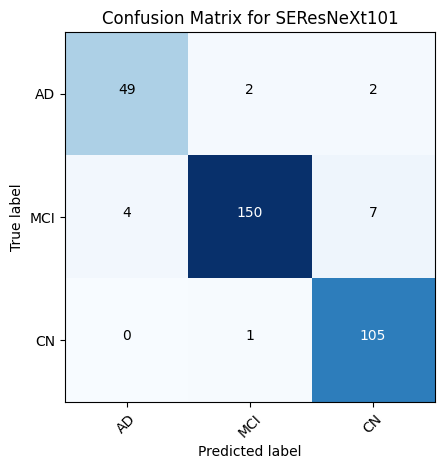

In [105]:
y_pred_classes = np.argmax(y_pred1, axis=1)
y_true = np.argmax(true_vals, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
def plot_confusion_matrix(cm, classes, normalize=False, title="", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Val Set Normalized confusion matrix")
    else:
        print("Val Set Confusion matrix")
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
class_names =  ["AD", "MCI", "CN"]
plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix for SEResNeXt101", cmap=plt.cm.Blues)
plt.savefig('results/SEResNeXt101.png', bbox_inches='tight')

Val Set Confusion matrix


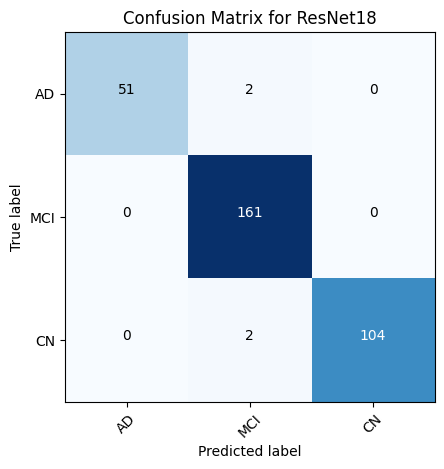

In [106]:
y_pred_classes = np.argmax(y_pred2, axis=1)
y_true = np.argmax(true_vals, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
class_names =  ["AD", "MCI", "CN"]
plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix for ResNet18", cmap=plt.cm.Blues)
plt.savefig('results/ResNet18.png', bbox_inches='tight')

Val Set Confusion matrix


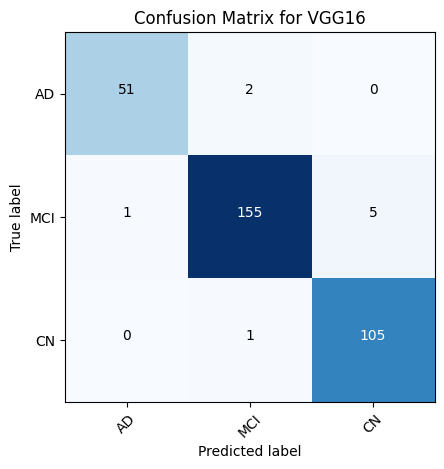

In [107]:
y_pred_classes = np.argmax(y_pred3, axis=1)
y_true = np.argmax(true_vals, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
class_names =  ["AD", "MCI", "CN"]
plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix for VGG16", cmap=plt.cm.Blues)
plt.savefig('results/VGG16.png', bbox_inches='tight')

Val Set Confusion matrix


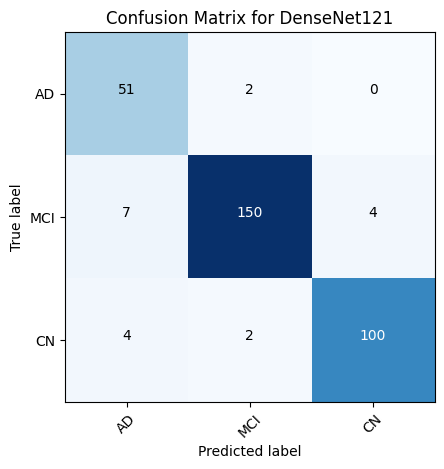

In [108]:
y_pred_classes = np.argmax(y_pred4, axis=1)
y_true = np.argmax(true_vals, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
class_names =  ["AD", "MCI", "CN"]
plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix for DenseNet121", cmap=plt.cm.Blues)
plt.savefig('results/DenseNet121.png', bbox_inches='tight')